In [1]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Hallo leute! Today’s post we will implement the awesome model to learn word embeddings Glove: Global Vectors for Word Representation, using Pytorch. Developed by Stanford, the main idea is to leverage the matrix of word cooccurrences in order to extract “dimensions of meaning”, outputing word vectors that naturally captures word semantics and thus being useful representations in a lot of tasks, such word analogies. You can find more information in the original paper here .

For this project, we will use the text8 dataset (that can be download here). This dataset is a dump of cleaned wikipedia texts. More details here .

First, we just import the necessary libs.

In [2]:
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE

Next we will create a dataset class to manage our feature extraction and batch generation. We must create a cooccurence matrix for every word to feed the glove model. We will generate a vocab of ~190k words. If we create a common matrix, it would have 190000² entries, which would result in ~36 billion entries. If we consider each value a 32bit integer, we are talking of ~135GB of memory, too much to store and process. To handle this issue we can leverage the fact that most of the entries of this matrix are 0 so we just need to store the non-zero values, which drastically reduce the amount of memory necessary.

In [3]:
english_text_python_program_pair_list = []
process_python_code=False
i=1
with open('dataset_python_cleaned_final.txt', 'r', encoding="utf8") as f:
    for line in f:
        #print(i)
        i += 1
        if process_python_code==False:
            if line.strip() == '':
                continue
            if line.startswith('#'):
                english_text = line
                #english_text_list.append(line)
                process_python_code=True
                python_program=''
            else:
                print(i, ": ", line)            
        else:
            if line.strip() == '':
                process_python_code=False
                english_text_python_program_pair_list.append((english_text, python_program))
                python_program=''
                english_text =''
            if line.lstrip().startswith('#'):
                continue
            else:
                python_program += line

In [4]:
len(english_text_python_program_pair_list)

4725

In [5]:
import json
# Opening JSON file 
with open('conala-corpus/conala-combined.json') as f: 
    # returns JSON object as  
    # a dictionary 
    data = json.load(f) 
    for record in data:
        english_text_python_program_pair_list.append((record['intent'],record['snippet'] ))
        english_text_python_program_pair_list.append((record['rewritten_intent'],record['snippet'] ))

In [6]:
print(english_text_python_program_pair_list)

[('# write a python program to add two numbers \n', "num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\nprint(f'Sum: {sum}')\n"), ('# write a python function to add two user provided numbers and return the sum\n', 'def add_two_numbers(num1, num2):\n    sum = num1 + num2\n    return sum\n'), ('# write a program to find and print the largest among three numbers\n', "num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >= num2) and (num1 >= num3):\n   largest = num1\nelif (num2 >= num1) and (num2 >= num3):\n   largest = num2\nelse:\n   largest = num3\nprint(f'largest:{largest}')\n"), ('# write a program to find and print the smallest among three numbers\n', "num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= num2) and (num1 <= num3):\n   smallest = num1\nelif (num2 <= num1) and (num2 <= num3):\n   smallest = num2\nelse:\n   smallest = num3\nprint(f'smallest:{smallest}')\n"), ('# Write a python function to merge two given lists into one\n', 'def merge_lists(l1, l2):\n    return l1 + l2\n'), ('# Write a program to 

In [7]:
english_text_list,python_program_list  = zip(*english_text_python_program_pair_list)

In [8]:
english_text_list

('# write a python program to add two numbers \n',
 '# write a python function to add two user provided numbers and return the sum\n',
 '# write a program to find and print the largest among three numbers\n',
 '# write a program to find and print the smallest among three numbers\n',
 '# Write a python function to merge two given lists into one\n',
 '# Write a program to check whether a number is prime or not\n',
 '# Write a python function that prints the factors of a given number\n',
 '# Write a program to find the factorial of a number\n',
 '# Write a python function to print whether a number is negative, positive or zero\n',
 '# Write a program to print the multiplication table of a given number\n',
 '# Write a python function to print powers of 2, for given number of terms\n',
 '# Write a program to filter the numbers in a list which are divisible by a given number\n',
 '# Write a python function that returns the sum of n natural numbers\n',
 '# Write a program to swap first and la

In [9]:
import pandas as pd

df = pd.DataFrame({'English': english_text_list, 'Python':python_program_list })

In [10]:
df['English'].head(10)

0       # write a python program to add two numbers \n
1    # write a python function to add two user prov...
2    # write a program to find and print the larges...
3    # write a program to find and print the smalle...
4    # Write a python function to merge two given l...
5    # Write a program to check whether a number is...
6    # Write a python function that prints the fact...
7    # Write a program to find the factorial of a n...
8    # Write a python function to print whether a n...
9    # Write a program to print the multiplication ...
Name: English, dtype: object

In [11]:
len(english_text_python_program_pair_list)

10483

In [12]:
import nltk
import string
import re

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer


from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
import string
import nltk
import random
import random
#import google_trans_new
#from google_trans_new import google_translator

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
lem = WordNetLemmatizer()
#translator = google_translator()

def clean_text(text):
    ## lower case
    if not isinstance(text, str):
      return str(text) 
    cleaned = text.lower()

    urls_pattern = re.compile(r'https?://\S+|www.\S+')
    cleaned = urls_pattern.sub(r'',cleaned)
    
    ## remove punctuations
    punctuations = string.punctuation
    cleaned_temp = "".join(character for character in cleaned if character not in punctuations)
    
    ## remove stopwords 
    words = cleaned_temp.split()
    #stopword_lists = stopwords.words("english")
    #cleaned = [word for word in words if word not in stopword_lists]
    cleaned = words
    
    ## normalization - lemmatization
    # cleaned = [lem.lemmatize(word, "v") for word in cleaned]
    # cleaned = [lem.lemmatize(word, "n") for word in cleaned]
    
    ## join 
    cleaned = " ".join(cleaned)
    return cleaned

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\monim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\monim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\monim\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [13]:
import tokenize
import io

english_token_list = []

for english_text in english_text_list:
    if english_text is not None:
        english_token_list.append("<sos>")
        english_token_list.extend(clean_text(english_text).split())
        english_token_list.append("<eos>")

In [14]:
english_token_list

['<sos>',
 'write',
 'a',
 'python',
 'program',
 'to',
 'add',
 'two',
 'numbers',
 '<eos>',
 '<sos>',
 'write',
 'a',
 'python',
 'function',
 'to',
 'add',
 'two',
 'user',
 'provided',
 'numbers',
 'and',
 'return',
 'the',
 'sum',
 '<eos>',
 '<sos>',
 'write',
 'a',
 'program',
 'to',
 'find',
 'and',
 'print',
 'the',
 'largest',
 'among',
 'three',
 'numbers',
 '<eos>',
 '<sos>',
 'write',
 'a',
 'program',
 'to',
 'find',
 'and',
 'print',
 'the',
 'smallest',
 'among',
 'three',
 'numbers',
 '<eos>',
 '<sos>',
 'write',
 'a',
 'python',
 'function',
 'to',
 'merge',
 'two',
 'given',
 'lists',
 'into',
 'one',
 '<eos>',
 '<sos>',
 'write',
 'a',
 'program',
 'to',
 'check',
 'whether',
 'a',
 'number',
 'is',
 'prime',
 'or',
 'not',
 '<eos>',
 '<sos>',
 'write',
 'a',
 'python',
 'function',
 'that',
 'prints',
 'the',
 'factors',
 'of',
 'a',
 'given',
 'number',
 '<eos>',
 '<sos>',
 'write',
 'a',
 'program',
 'to',
 'find',
 'the',
 'factorial',
 'of',
 'a',
 'number',
 '<

In [15]:
len(english_token_list)

137321

In [16]:
class GloveDataset:

  def __init__(self, english_token_list, n_words=200000, window_size=5):
      self._window_size = window_size
      self._tokens = english_token_list[:n_words]
      word_counter = Counter()
      word_counter.update(self._tokens)
      self._word2id = {w:i for i, (w,_) in enumerate(word_counter.most_common())}
      self._id2word = {i:w for w, i in self._word2id.items()}
      self._vocab_len = len(self._word2id)

      self._id_tokens = [self._word2id[w] for w in self._tokens]

      self._create_coocurrence_matrix()

      print("# of words: {}".format(len(self._tokens)))
      print("Vocabulary length: {}".format(self._vocab_len))

  def _create_coocurrence_matrix(self):
      cooc_mat = defaultdict(Counter)
      for i, w in enumerate(self._id_tokens):
          start_i = max(i - self._window_size, 0)
          end_i = min(i + self._window_size + 1, len(self._id_tokens))
          for j in range(start_i, end_i):
              if i != j:
                  c = self._id_tokens[j]
                  cooc_mat[w][c] += 1 / abs(j-i)

      self._i_idx = list()
      self._j_idx = list()
      self._xij = list()

      #Create indexes and x values tensors
      for w, cnt in cooc_mat.items():
          for c, v in cnt.items():
              self._i_idx.append(w)
              self._j_idx.append(c)
              self._xij.append(v)

      self._i_idx = torch.LongTensor(self._i_idx).cuda()
      self._j_idx = torch.LongTensor(self._j_idx).cuda()
      self._xij = torch.FloatTensor(self._xij).cuda()


  def get_batches(self, batch_size):
      #Generate random idx
      rand_ids = torch.LongTensor(np.random.choice(len(self._xij), len(self._xij), replace=False))

      for p in range(0, len(rand_ids), batch_size):
          batch_ids = rand_ids[p:p+batch_size]
          yield self._xij[batch_ids], self._i_idx[batch_ids], self._j_idx[batch_ids]

dataset = GloveDataset(english_token_list, 10000000)

# of words: 137321
Vocabulary length: 4572


Here we create the class of our glove model. In its forward pass it will perform the yellow part of the Glove loss function, described in the original paper:

![](https://cdn.hashnode.com/res/hashnode/image/upload/v1587152473299/6HedPZypj.png?auto=compress)


In [17]:
EMBED_DIM = 300
class GloveModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(GloveModel, self).__init__()
        self.wi = nn.Embedding(num_embeddings, embedding_dim)
        self.wj = nn.Embedding(num_embeddings, embedding_dim)
        self.bi = nn.Embedding(num_embeddings, 1)
        self.bj = nn.Embedding(num_embeddings, 1)

        self.wi.weight.data.uniform_(-1, 1)
        self.wj.weight.data.uniform_(-1, 1)
        self.bi.weight.data.zero_()
        self.bj.weight.data.zero_()

    def forward(self, i_indices, j_indices):
        w_i = self.wi(i_indices)
        w_j = self.wj(j_indices)
        b_i = self.bi(i_indices).squeeze()
        b_j = self.bj(j_indices).squeeze()

        x = torch.sum(w_i * w_j, dim=1) + b_i + b_j

        return x
glove = GloveModel(dataset._vocab_len, EMBED_DIM)
glove.cuda()


GloveModel(
  (wi): Embedding(4572, 300)
  (wj): Embedding(4572, 300)
  (bi): Embedding(4572, 1)
  (bj): Embedding(4572, 1)
)

We must define a function to compute the weighting term f(Xij) of the loss function as per described in the paper:


![](https://cdn.hashnode.com/res/hashnode/image/upload/v1587152743199/bjCyXW0Wc.png?auto=compress)


In [18]:
def weight_func(x, x_max, alpha):
    wx = (x/x_max)**alpha
    wx = torch.min(wx, torch.ones_like(wx))
    return wx.cuda()


The loss function described in the Glove paper is a weighted mean squared error. Pytorch 1.0 doesn’t have implementation for it, so we must write it ourselves. A good practice is to reuse any piece of this function already implemented so we take advantage of any optimization it might have:

In [19]:
def wmse_loss(weights, inputs, targets):
    loss = weights * F.mse_loss(inputs, targets, reduction='none')
    return torch.mean(loss).cuda()


Although we are using a diferent configuration (like the dataset) of the original paper, we will use the same optimizer and learning rate it describes.

In [20]:
optimizer = optim.Adagrad(glove.parameters(), lr=0.05)


Now we can write our training loop. The ALPHA and X_MAX parameters are set accoring to the paper. We also save our model states every 100 epochs.

In [21]:
N_EPOCHS = 50
BATCH_SIZE = 512
X_MAX = 100
ALPHA = 0.75
n_batches = int(len(dataset._xij) / BATCH_SIZE)
loss_values = list()
for e in range(1, N_EPOCHS+1):
    batch_i = 0

    for x_ij, i_idx, j_idx in dataset.get_batches(BATCH_SIZE):

        batch_i += 1

        optimizer.zero_grad()

        outputs = glove(i_idx, j_idx)
        weights_x = weight_func(x_ij, X_MAX, ALPHA)
        loss = wmse_loss(weights_x, outputs, torch.log(x_ij))

        loss.backward()

        optimizer.step()

        loss_values.append(loss.item())

        if batch_i % 100 == 0:
            print("Epoch: {}/{} \t Batch: {}/{} \t Loss: {}".format(e, N_EPOCHS, batch_i, n_batches, np.mean(loss_values[-20:])))  

    print("Saving model...")
    torch.save(glove.state_dict(), "glove_combined_300_english.pt")


Epoch: 1/50 	 Batch: 100/348 	 Loss: 1.51213396191597
Epoch: 1/50 	 Batch: 200/348 	 Loss: 1.5881738364696503
Epoch: 1/50 	 Batch: 300/348 	 Loss: 1.3892051041126252
Saving model...
Epoch: 2/50 	 Batch: 100/348 	 Loss: 0.5154556885361672
Epoch: 2/50 	 Batch: 200/348 	 Loss: 0.4984369859099388
Epoch: 2/50 	 Batch: 300/348 	 Loss: 0.5055860862135887
Saving model...
Epoch: 3/50 	 Batch: 100/348 	 Loss: 0.28957378342747686
Epoch: 3/50 	 Batch: 200/348 	 Loss: 0.2860015906393528
Epoch: 3/50 	 Batch: 300/348 	 Loss: 0.2925102137029171
Saving model...
Epoch: 4/50 	 Batch: 100/348 	 Loss: 0.20005832836031914
Epoch: 4/50 	 Batch: 200/348 	 Loss: 0.20676863193511963
Epoch: 4/50 	 Batch: 300/348 	 Loss: 0.20845501571893693
Saving model...
Epoch: 5/50 	 Batch: 100/348 	 Loss: 0.15647763162851333
Epoch: 5/50 	 Batch: 200/348 	 Loss: 0.14855073690414428
Epoch: 5/50 	 Batch: 300/348 	 Loss: 0.16418423540890217
Saving model...
Epoch: 6/50 	 Batch: 100/348 	 Loss: 0.13124609738588333
Epoch: 6/50 	 Batc

Epoch: 44/50 	 Batch: 100/348 	 Loss: 0.00792186560574919
Epoch: 44/50 	 Batch: 200/348 	 Loss: 0.007843805430456995
Epoch: 44/50 	 Batch: 300/348 	 Loss: 0.008701145625673234
Saving model...
Epoch: 45/50 	 Batch: 100/348 	 Loss: 0.008105533965863287
Epoch: 45/50 	 Batch: 200/348 	 Loss: 0.008295966545119882
Epoch: 45/50 	 Batch: 300/348 	 Loss: 0.008369815675541759
Saving model...
Epoch: 46/50 	 Batch: 100/348 	 Loss: 0.007808666327036917
Epoch: 46/50 	 Batch: 200/348 	 Loss: 0.00830808044411242
Epoch: 46/50 	 Batch: 300/348 	 Loss: 0.008050884935073555
Saving model...
Epoch: 47/50 	 Batch: 100/348 	 Loss: 0.007087054429575801
Epoch: 47/50 	 Batch: 200/348 	 Loss: 0.007925011147744954
Epoch: 47/50 	 Batch: 300/348 	 Loss: 0.007255870150402188
Saving model...
Epoch: 48/50 	 Batch: 100/348 	 Loss: 0.007206584559753537
Epoch: 48/50 	 Batch: 200/348 	 Loss: 0.007263303571380675
Epoch: 48/50 	 Batch: 300/348 	 Loss: 0.007522401981987059
Saving model...
Epoch: 49/50 	 Batch: 100/348 	 Loss:

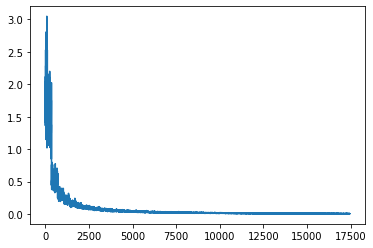

In [22]:
plt.plot(loss_values)

Here we sum over the two embedding matrices (as per recommendation of the original paper) to improve results. We then plot the TSNE space of the top 300 words to validate our word embeddings.

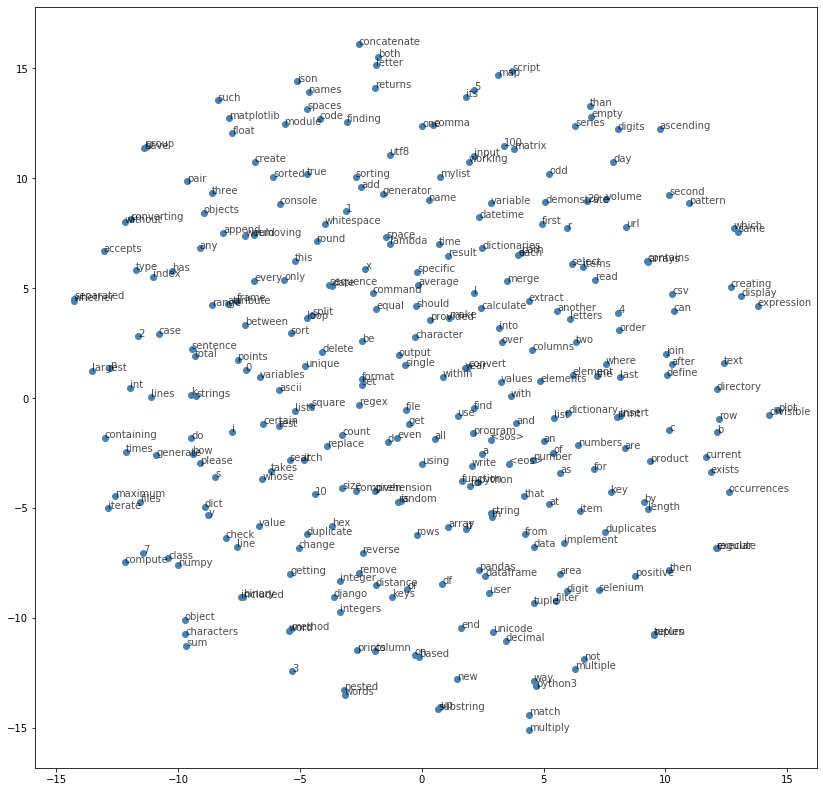

In [23]:
emb_i = glove.wi.weight.cpu().data.numpy()
emb_j = glove.wj.weight.cpu().data.numpy()
emb = emb_i + emb_j
top_k = 300
tsne = TSNE(metric='cosine', random_state=123)
embed_tsne = tsne.fit_transform(emb[:top_k, :])
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(top_k):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(dataset._id2word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)


In [24]:
glove_model = GloveModel(dataset._vocab_len, EMBED_DIM)
glove_model.load_state_dict(torch.load('glove_combined_300_english.pt'))


<All keys matched successfully>

In [25]:
dir(glove_model)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_version',
 'add_module',
 'apply',
 'bi',
 'bj',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'float',
 'forward',
 'half',
 'load_state_dict',
 'modules',
 'na

In [26]:
glove_model.state_dict()

OrderedDict([('wi.weight',
              tensor([[-0.4239,  0.5978, -0.4121,  ..., -0.6399,  0.7882, -0.0648],
                      [ 0.0422, -0.0711, -0.7511,  ..., -0.7289,  0.7069,  0.3667],
                      [-0.8647, -0.5558,  0.6189,  ...,  0.2034, -0.2293, -0.3809],
                      ...,
                      [ 0.0671, -0.9108, -0.0099,  ..., -0.6109,  0.1301, -0.9660],
                      [-0.4244,  0.1667,  0.0220,  ..., -0.8582,  0.2775,  0.4989],
                      [-0.8029, -0.6108, -0.7441,  ..., -0.2691, -0.5802, -0.6881]])),
             ('wj.weight',
              tensor([[ 0.5473, -0.0539, -0.0410,  ...,  0.0974,  0.0887, -0.6098],
                      [-0.6632,  0.1343,  0.4863,  ..., -0.4663,  0.0715, -0.0605],
                      [ 0.4295, -0.1094,  0.4455,  ...,  0.1794,  0.2988, -0.0203],
                      ...,
                      [ 0.3763, -0.5142,  0.5891,  ...,  0.7901,  0.9798,  0.4723],
                      [-0.4446, -0.1828, -0.1325,

Checking the words that are close, we can say that our model performs pretty good! We can check that it clusters the direction words north, south, west, east and even central. It also clusters together words with their plural form like system/systems and language/languages.

In [27]:
glove_model.state_dict()['wi.weight']

tensor([[-0.4239,  0.5978, -0.4121,  ..., -0.6399,  0.7882, -0.0648],
        [ 0.0422, -0.0711, -0.7511,  ..., -0.7289,  0.7069,  0.3667],
        [-0.8647, -0.5558,  0.6189,  ...,  0.2034, -0.2293, -0.3809],
        ...,
        [ 0.0671, -0.9108, -0.0099,  ..., -0.6109,  0.1301, -0.9660],
        [-0.4244,  0.1667,  0.0220,  ..., -0.8582,  0.2775,  0.4989],
        [-0.8029, -0.6108, -0.7441,  ..., -0.2691, -0.5802, -0.6881]])

In [28]:
dataset._word2id

{'<sos>': 0,
 '<eos>': 1,
 'a': 2,
 'to': 3,
 'of': 4,
 'the': 5,
 'python': 6,
 'write': 7,
 'in': 8,
 'list': 9,
 'string': 10,
 'and': 11,
 'function': 12,
 'program': 13,
 'from': 14,
 'print': 15,
 'with': 16,
 'how': 17,
 'number': 18,
 'dictionary': 19,
 'that': 20,
 'given': 21,
 'get': 22,
 'by': 23,
 'all': 24,
 'is': 25,
 'two': 26,
 'numbers': 27,
 'convert': 28,
 'values': 29,
 'using': 30,
 'value': 31,
 'find': 32,
 'if': 33,
 'an': 34,
 'into': 35,
 'check': 36,
 'elements': 37,
 'array': 38,
 'file': 39,
 'for': 40,
 'return': 41,
 'element': 42,
 'remove': 43,
 'sort': 44,
 'pandas': 45,
 'dataframe': 46,
 'lists': 47,
 'which': 48,
 'key': 49,
 'each': 50,
 'column': 51,
 'as': 52,
 'i': 53,
 'on': 54,
 'it': 55,
 'are': 56,
 'between': 57,
 'first': 58,
 '1': 59,
 'input': 60,
 'characters': 61,
 'sum': 62,
 'or': 63,
 'tuples': 64,
 'tuple': 65,
 'index': 66,
 'create': 67,
 'calculate': 68,
 'can': 69,
 'strings': 70,
 'keys': 71,
 'length': 72,
 'data': 73,
 'n':

In [29]:
dataset._word2id['multiply']

249

In [30]:
glove_model.state_dict()['wi.weight'][dataset._word2id['multiply']] + glove_model.state_dict()['wj.weight'][dataset._word2id['multiply']]

tensor([-0.3831, -0.1535,  0.4140, -1.2856, -0.5255,  1.4772, -0.8843, -0.7493,
        -1.0274, -0.5980,  0.6360, -0.4348,  0.3767, -0.7613, -0.2423, -0.0307,
        -0.5751, -0.7912, -0.1514,  0.3063,  0.7263,  1.3054,  1.2570, -0.4199,
         0.5422,  1.6766,  0.8372, -0.5153,  0.0514,  0.3060,  1.1653,  0.4544,
         0.7018, -0.9079,  1.0795,  0.2462,  0.4614,  1.6245, -0.2095,  1.0721,
        -0.3557, -1.2939, -0.3821, -0.1242,  1.3518, -0.0672, -0.4776,  0.2863,
         1.7089, -0.0206, -0.5753,  1.1094, -0.0881,  0.2509,  0.1283, -1.5621,
         0.1477, -1.2403,  0.0871, -0.0494,  0.3070,  1.3580, -0.3296,  0.2118,
        -0.0206,  0.3016,  0.4532, -1.2594,  0.1002,  0.9580,  0.1564,  0.0457,
        -0.1246,  0.4577,  1.0457, -1.1151, -0.7009, -0.2380,  0.6868, -0.0949,
         1.1059,  0.6015,  0.8900,  0.2597, -0.6371, -0.4086, -0.7825,  1.5452,
         0.8598, -1.0752,  0.7488,  0.1548, -0.2053, -0.8624,  0.8803,  1.0871,
         0.4807, -0.4437, -0.3415, -1.05

In [31]:
import pickle
with open('combined_dataset_vocab_300_english.pkl', 'wb') as tokens: 
    pickle.dump(dataset._word2id, tokens)

In [32]:
object_dict = None
with open('combined_dataset_vocab_300_english.pkl',  'rb' ) as f:
    object_dict = pickle.load(f)

In [33]:
object_dict

{'<sos>': 0,
 '<eos>': 1,
 'a': 2,
 'to': 3,
 'of': 4,
 'the': 5,
 'python': 6,
 'write': 7,
 'in': 8,
 'list': 9,
 'string': 10,
 'and': 11,
 'function': 12,
 'program': 13,
 'from': 14,
 'print': 15,
 'with': 16,
 'how': 17,
 'number': 18,
 'dictionary': 19,
 'that': 20,
 'given': 21,
 'get': 22,
 'by': 23,
 'all': 24,
 'is': 25,
 'two': 26,
 'numbers': 27,
 'convert': 28,
 'values': 29,
 'using': 30,
 'value': 31,
 'find': 32,
 'if': 33,
 'an': 34,
 'into': 35,
 'check': 36,
 'elements': 37,
 'array': 38,
 'file': 39,
 'for': 40,
 'return': 41,
 'element': 42,
 'remove': 43,
 'sort': 44,
 'pandas': 45,
 'dataframe': 46,
 'lists': 47,
 'which': 48,
 'key': 49,
 'each': 50,
 'column': 51,
 'as': 52,
 'i': 53,
 'on': 54,
 'it': 55,
 'are': 56,
 'between': 57,
 'first': 58,
 '1': 59,
 'input': 60,
 'characters': 61,
 'sum': 62,
 'or': 63,
 'tuples': 64,
 'tuple': 65,
 'index': 66,
 'create': 67,
 'calculate': 68,
 'can': 69,
 'strings': 70,
 'keys': 71,
 'length': 72,
 'data': 73,
 'n':

In [34]:
import torch
import torchvision
import torchtext

In [35]:
torch.__version__

'1.4.0'

In [36]:
torchvision.__version__

'0.5.0'

In [37]:
torchtext.__version__

'0.6.0'